# 2. Topic modelling

## Setup

In [1]:
%run __init__.py

In [2]:
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/home/alejandro/.envs/edma/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
RANDOM_SEED=42

## Loading the dataframe

In [4]:
GIT_FILE_PATH = os.path.join(NOTEBOOK_1_RESULTS_DIR, 'git_dataframe.pkl')

git_df = pd.read_pickle(GIT_FILE_PATH)

## Preprocessing text

In [5]:
git_repositories = git_df['full_text_cleaned'].values

In [6]:
import en_core_web_md

from herc_common.text import TextPreprocessor


custom_stop_words = {"merge", "branch", "master", "refs", "svn",
                     "branch", "pull", "request", "fix", "ref",
                     "error", "add", "file", "bug"}

git_preprocessor = TextPreprocessor(en_core_web_md, custom_stop_words)
preprocessed_texts = git_preprocessor.fit_transform(git_repositories)

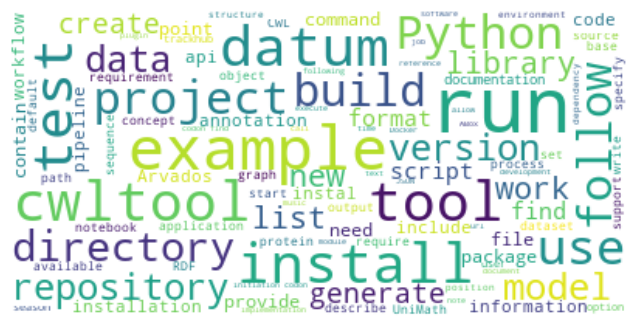

In [7]:
from herc_common.text import plot_word_cloud

complete_text = ' '.join([' '.join(token) for token in preprocessed_texts])

plot_word_cloud(complete_text)

## LDA

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc


tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
dtm_tf = tf_vectorizer.fit_transform(preprocessed_texts)

In [53]:
from sklearn.decomposition import LatentDirichletAllocation

from herc_common.topic_modeling import base_scoring_function, compute_model_results


lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tf_vectorizer,
                                        texts=preprocessed_texts, model=clf, X=X)


lda_results = compute_model_results(LatentDirichletAllocation, dtm_tf,
                                    lda_scoring_func, seed=RANDOM_SEED,
                                    min_topics=5, max_topics=70, max_iter=100)
lda_results

{LatentDirichletAllocation(max_iter=100, n_components=5, random_state=42): -5.915253478324617,
 LatentDirichletAllocation(max_iter=100, n_components=6, random_state=42): -5.696511148095404,
 LatentDirichletAllocation(max_iter=100, n_components=7, random_state=42): -5.936280373853497,
 LatentDirichletAllocation(max_iter=100, n_components=8, random_state=42): -5.680961661456242,
 LatentDirichletAllocation(max_iter=100, n_components=9, random_state=42): -5.942800844503774,
 LatentDirichletAllocation(max_iter=100, random_state=42): -5.799049452305608,
 LatentDirichletAllocation(max_iter=100, n_components=11, random_state=42): -5.111516973425034,
 LatentDirichletAllocation(max_iter=100, n_components=12, random_state=42): -5.563673263695809,
 LatentDirichletAllocation(max_iter=100, n_components=13, random_state=42): -5.200861298728504,
 LatentDirichletAllocation(max_iter=100, n_components=14, random_state=42): -5.670329257611129,
 LatentDirichletAllocation(max_iter=100, n_components=15, rand

In [54]:
from herc_common.topic_modeling import get_best_model, print_results_info

print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

Best model parameters: {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 100, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
Topic coherence: -3.1257837736713907


In [55]:
from herc_common.topic_modeling import print_top_words

tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 10)

Topic #0: annotation protein structure example datum SARS sentence project reference sequence
Topic #1: BioSample record BioSample record RDF model JSON provide BioSample RDF BioSamples code
Topic #2: web application Russ BioScholar web BioScholar describe Russ application describe web describe application original
Topic #3: check info TBox concept example format definition subsumption ejemplos reasoner
Topic #4: model base run music refer feature end file learning notebook
Topic #5: folder JSON format like JSON format experimental project list file relate link point sequence
Topic #6: MMTF include test sentence que generate code directory Wasserstein dataset
Topic #7: codon position Arvados find codon find initiation initiation codon run frame transcript
Topic #8: TERMite termite specify import pprint library endpoint entity example TExpress
Topic #9: trackhub pipeline application project process create give data information datum
Topic #10: run test install server task funnel cwl tox

In [56]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
13     -10.878068   10.538728       1        1  16.637848
7      -60.884026  -75.591820       2        1  14.318448
17      -2.336119  -53.289074       3        1  10.267037
6      -61.385319  -12.914634       4        1   8.128434
9      -28.737743  126.296997       5        1   7.669370
3        1.066606 -123.552811       6        1   7.509971
0       45.140720   -7.947869       7        1   6.813272
12    -140.795975  -98.530548       8        1   6.289709
19      61.531681  -83.240562       9        1   5.455341
14     -72.563057 -140.396881      10        1   2.771714
15      15.984491   63.578186      11        1   2.632650
16    -160.851624   68.945145      12        1   1.838233
18      85.961830   51.922935      13        1   1.755790
4      -99.020836  109.936348      14        1   1.723714
11    -176.764130   -8.681684      15        1   1.563674
10    -117.189880  -37.420200      16        1   1.542153
8      108.829918  -22.946203      17        1   1.274642
1       47.588097  121.934814      18        1   0.911112
5     -106.467834   30.176889      19        1   0.734093
2      -50.613804   59.328842      20        1   0.162795, topic_info=                 Term       Freq      Total Category  logprob  loglift
3565          cwltool  51.000000  51.000000  Default  30.0000  30.0000
8229              run  84.000000  84.000000  Default  29.0000  29.0000
9299             test  51.000000  51.000000  Default  28.0000  28.0000
9532         trackhub  24.000000  24.000000  Default  27.0000  27.0000
3025            codon  26.000000  26.000000  Default  26.0000  26.0000
...               ...        ...        ...      ...      ...      ...
3423      coq library   0.002802   0.915026  Topic20  -9.2937   0.6317
3424             core   0.002802   1.237307  Topic20  -9.2937   0.3299
3430          correct   0.002802   1.382967  Topic20  -9.2937   0.2186
3429  corpus generate   0.002802   1.271694  Topic20  -9.2937   0.3025
3428           corpus   0.002802   1.271694  Topic20  -9.2937   0.3025

[1775 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
2          6  0.966704       ABox
12         7  0.833293       AIDA
33         2  0.898455        AUG
34         2  0.898455  AUG codon
45        13  0.589751     Ahrens
...      ...       ...        ...
10245      1  0.422711        xml
10245      3  0.422711        xml
10245      9  0.211356        xml
10261      1  0.830574      yield
10270     14  0.771265    youtube

[1810 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 8, 18, 7, 10, 4, 1, 13, 20, 15, 16, 17, 19, 5, 12, 11, 9, 2, 6, 3])

# LSA

In [58]:
from sklearn.decomposition import TruncatedSVD

lsa_scoring_func = lda_scoring_func

lsa_results = compute_model_results(TruncatedSVD, dtm_tf, lsa_scoring_func, 
                                    seed=RANDOM_SEED, min_topics=5,
                                    max_topics=50)
lsa_results

{TruncatedSVD(n_components=5, random_state=42): -2.7263184184549134,
 TruncatedSVD(n_components=6, random_state=42): -2.6647755201085337,
 TruncatedSVD(n_components=7, random_state=42): -3.298584424246684,
 TruncatedSVD(n_components=8, random_state=42): -2.831036038245638,
 TruncatedSVD(n_components=9, random_state=42): -3.1808049443374693,
 TruncatedSVD(n_components=10, random_state=42): -3.2316908823168626,
 TruncatedSVD(n_components=11, random_state=42): -2.984664162386707,
 TruncatedSVD(n_components=12, random_state=42): -3.001153408162706,
 TruncatedSVD(n_components=13, random_state=42): -2.832399269239328,
 TruncatedSVD(n_components=14, random_state=42): -2.6832688225731802,
 TruncatedSVD(n_components=15, random_state=42): -2.6879406831593773,
 TruncatedSVD(n_components=16, random_state=42): -2.5454683105025238,
 TruncatedSVD(n_components=17, random_state=42): -2.4126839215778904,
 TruncatedSVD(n_components=18, random_state=42): -2.807065196250012,
 TruncatedSVD(n_components=19, 

## NMF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)

In [52]:
from sklearn.decomposition import NMF

nmf_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tfidf_vectorizer,
                                                        texts=preprocessed_texts, model=clf, X=X)

nmf_results = compute_model_results(NMF, dtm_tfidf, nmf_scoring_func, 
                                    seed=RANDOM_SEED, min_topics=5,
                                    max_topics=60, max_iter=400)
nmf_results

{NMF(max_iter=400, n_components=5, random_state=42): -7.935856151197635,
 NMF(max_iter=400, n_components=6, random_state=42): -8.65033585388065,
 NMF(max_iter=400, n_components=7, random_state=42): -8.737277866304234,
 NMF(max_iter=400, n_components=8, random_state=42): -9.451160298235695,
 NMF(max_iter=400, n_components=9, random_state=42): -8.83011624116053,
 NMF(max_iter=400, n_components=10, random_state=42): -8.556493414152614,
 NMF(max_iter=400, n_components=11, random_state=42): -9.019773614025173,
 NMF(max_iter=400, n_components=12, random_state=42): -8.546481259694266,
 NMF(max_iter=400, n_components=13, random_state=42): -8.71387563482617,
 NMF(max_iter=400, n_components=14, random_state=42): -8.744603376643962,
 NMF(max_iter=400, n_components=15, random_state=42): -8.170223764979472,
 NMF(max_iter=400, n_components=16, random_state=42): -8.489916357133389,
 NMF(max_iter=400, n_components=17, random_state=42): -7.930996558687182,
 NMF(max_iter=400, n_components=18, random_sta

In [49]:
print_results_info(nmf_results)
best_nmf_model = get_best_model(nmf_results)

Best model parameters: {'alpha': 0.0, 'beta_loss': 'frobenius', 'init': None, 'l1_ratio': 0.0, 'max_iter': 400, 'n_components': 64, 'random_state': 42, 'shuffle': False, 'solver': 'cd', 'tol': 0.0001, 'verbose': 0}
Topic coherence: -1.9626285649215847


In [50]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(best_nmf_model, tfidf_feature_names, 10)

Topic #0: run dependency test example environment source script point tool set
Topic #1: code web script find run documentation repository describe database include
Topic #2: menu catalog FDP dialog dropdown metadata distribution fill click field
Topic #3: library termite TERMite import example pprint specify call install docs
Topic #4: que para con traducir revisar las son traducción datos archivos
Topic #5: toolbox subpackage JSON ProvToolbox Provenance PROV representation java convert RDF
Topic #6: Arvados crunch workflow documentation arvados channel biomedical Arvbox storage manage
Topic #7: Cheat Data Pandas Science Python Learning sheet learning Machine Numpy
Topic #8: codon position initiation reading transcript wild frame variation signal find
Topic #9: sequence uploader SARS upload project use virtualenv venv print example
Topic #10: Termite JavaTermiteStarter retrieving Set basic annotation text call start code
Topic #11: Crisis Generalizability Yarkoni figure Schooler datum